In [1]:
import torch
import sak
import pickle
import cv2
import sak.torch.image.data

In [21]:
model = torch.load('C:/Users/hp240/Documents/IAGO/EBM/TFG/TrainedModels/14/model_best.model')
model.state_dict()
model.eval()

ModelWrapper(
  (operation): wnet(
    (encoder): basenet(
      (e0): encoder_block(
        (conv): conv_block(
          (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu0): ReLU()
          (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout0): Dropout(p=0.25, inplace=False)
          (relu1): ReLU()
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (dropout1): Dropout(p=0.25, inplace=False)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      )
      (e1): encoder_block(
        (conv): conv_block(
          (conv0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu0): ReLU()
          (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [22]:
# 2) Load test set
with open("C:/Users/hp240/Documents/IAGO/EBM/TFG/TrainedModels/14/execution_info.pkl", "rb") as f:
    keys_test = pickle.load(f)["keys_test"]

In [23]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pydicom
import sak
import glob
import os.path

# codigo para extraer el bias inicial y que la curva y el GT coincidan


# todo esto esta dentro del src.load_data

def get_region(dicom: pydicom.Dataset, ix_region: int):
    region  = dicom.get("SequenceOfUltrasoundRegions", [])[ix_region]
    x0      = region.RegionLocationMinX0
    x1      = region.RegionLocationMaxX1
    y0      = region.RegionLocationMinY0
    y1      = region.RegionLocationMaxY1
    xref    = region.ReferencePixelY0 if hasattr(region,"ReferencePixelX0")        else None
    yref    = region.ReferencePixelY0 if hasattr(region,"ReferencePixelY0")        else None
    deltax  = region.PhysicalDeltaX   if hasattr(region,"PhysicalDeltaX")          else None
    deltay  = region.PhysicalDeltaY   if hasattr(region,"PhysicalDeltaY")          else None

    return x0,x1,y0,y1,xref,yref,deltax,deltay

def get_frame(dicom: pydicom.Dataset, type: str = "doppler"):
    # Assert types
    if   type.lower() == "doppler":
        allowedSpatialFormats = [3]
        allowedDataTypes      = [3,4]
    elif type.lower() == "bmode":
        allowedSpatialFormats = [1]
        allowedDataTypes      = [1,2]
    elif type.lower() == "mmode":
        allowedSpatialFormats = [2]
        allowedDataTypes      = [1]
    else:
        raise ValueError(f"Frame type '{type}' not in ['doppler', 'bmode', 'mmode']")

    # Initialize values
    x0,x1,y0,y1,xref,yref,deltax,deltay,unitsx,unitsy = (None,None,None,None,None,None,None,None,None,None,)

    # Aggregate same doppler regions (DICOM format)
    first_match = False
    all_regions = dicom.get("SequenceOfUltrasoundRegions", [])
    for i,region in enumerate(all_regions):
        if ("RegionDataType" not in region):
            x0,x1,y0,y1,xref,yref,deltax,deltay,unitsx,unitsy = get_region(dicom,0)
        else:
            if (region.RegionDataType in allowedDataTypes) and (region.RegionSpatialFormat in allowedSpatialFormats):
                if first_match == False:
                    x0,x1,y0,y1,xref,yref,deltax,deltay = get_region(dicom,i)
                    first_match = True
                
                # Check if next region can be aggregated
                x0_new,x1_new,y0_new,y1_new,_,_,_,_ = get_region(dicom,i)
                if (y0 == y0_new) and (y1 == y1_new):
                    if x0_new <= x0:
                        x0 = x0_new
                    if x1_new >= x1:
                        x1 = x1_new
    
    return x0,x1,y0,y1,xref,yref,deltax,deltay

def get_modality(dicom: pydicom.Dataset):
    if "SequenceOfUltrasoundRegions" not in dicom:
        return None

    spatialformats,datatypes = [],[]
    for region in dicom.SequenceOfUltrasoundRegions:
        if ("RegionSpatialFormat" not in region) or ("RegionDataType" not in region):
            return None
        spatialformats.append(region.RegionSpatialFormat)
        datatypes.append(region.RegionDataType)
    spatialformats,datatypes = np.array(spatialformats),np.array(datatypes)

    # Determine type of image for analysis
    if   np.any(spatialformats == 2): # M-Mode
        modality = "M-Mode"
    elif np.any(spatialformats == 3):
        ix = np.where(spatialformats == 3)[0][0]
        if   datatypes[ix] == 3: # PW Spectral Doppler
            modality = "PW Doppler" # NEEDED DISTINGUISHING PW AND TDI (!!!)
        elif datatypes[ix] == 4: # CW Spectral Doppler
            modality = "CW Doppler"
        else: # Unknown
            modality = None
    elif np.all(spatialformats == 1) and (spatialformats.size == 1):
        modality = "2D"
    else:
        modality = None

    return modality

def convert_ybr_to_rgb(arr):
    if len(arr.shape) == 4:
        return np.vstack([convert_ybr_to_rgb(a)[np.newaxis] for a in arr])
    else:
        temp = arr[...,1].copy()
        arr[...,1] = arr[..., 2]
        arr[...,2] = temp
        return cv2.cvtColor(arr, cv2.COLOR_YCR_CB2RGB)

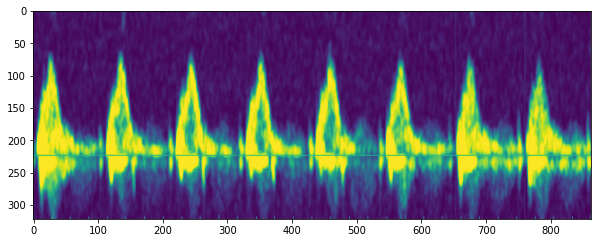

In [24]:
datadir = 'C:\\Users\\hp240\\Documents\\IAGO\\EBM\\TFG\\ALL_DOPPLER\\'

data = [datadir+i for i in keys_test]

path = data[23]
dicom = pydicom.dcmread(path)

x0,x1,y0,y1,xref,yref,deltax,deltay = get_frame(dicom,"doppler")

x = dicom.pixel_array.copy()[y0:y1,x0:x1,]
if dicom.get("PhotometricInterpretation", "RGB") in ['YBR_FULL', 'YBR_FULL_422']:
    x = convert_ybr_to_rgb(x)
x = x[...,0] # to grayscale

plt.figure(1,figsize=(10,10))

plt.imshow(x)

(256, 512)


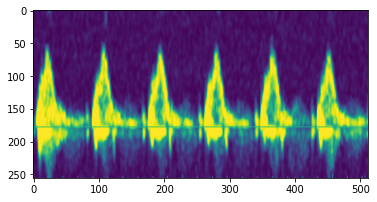

In [25]:
# hay que interpolar, es decir recortar el eje x para que al hacer reshape no se distorsione
shape = (256,512)
# quiero que sea 256x512
proporcion = shape[1] / shape[0]
x_side = x.shape[0]*2

# cropping:
x = x[:,0:x_side]
x = cv2.resize(x,(512,256))[None,]
x = x.squeeze()

print(x.shape)

plt.imshow(x)


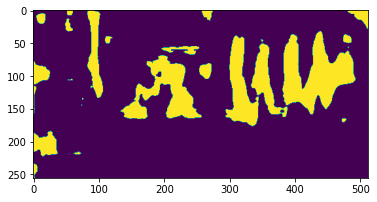

In [26]:
import sak.torch.image.data.augmentation

x_torch = torch.tensor(x)[None,None]

inputs = {'x' : x_torch.float()}

sak.torch.image.data.augmentation.RescaleIntensity(inputs)

output = model(inputs)
out_numpy = output['sigmoid'].cpu().detach().numpy().squeeze()

plt.imshow(out_numpy[2,:,:])